# Transfer Learning implémentation

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

## Fonctions du transfer learning

In [2]:
def compute_V(X):
    return np.dot(np.transpose(X), X)

def compute_W(lamda, X_s, X_b, X_t):
     V_s = compute_V(X_s)
     V_b = compute_V(X_b)
     V_b_inv = np.linalg.inv(V_b)
     V_t = compute_V(X_t)

     W = np.dot(np.linalg.inv(V_s + lamda*(np.dot(np.dot(V_t,V_b_inv),V_s)) + lamda*V_t), V_s + lamda*(np.dot(np.dot(V_t,V_b_inv),V_s)))
     return W

def compute_M(X_s, X_b):
    V_s = compute_V(X_s)
    V_b = compute_V(X_b)
    V_b_inv = np.linalg.inv(V_b)
    V_s_sqrt = sp.linalg.sqrtm(V_s)
    
    M = np.dot(np.dot(V_s_sqrt, V_b_inv), V_s_sqrt)
    
    return M

def compute_U_eigenval(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)

    U = eigenvectors
    diag_eigenval = np.diag(eigenvalues)
    nb_elt_on_diag = min(diag_eigenval.shape[0], diag_eigenval.shape[1])
    eigenvals = [diag_eigenval[i,i] for i in range(nb_elt_on_diag)]
    
    return U, eigenvals

def compute_beta_hat_s_or_b(X, Y):
    V = compute_V(X)
    V_inv = np.linalg.inv(V)
    
    beta_hat = np.dot(np.dot(V_inv, np.transpose(X)), Y)
    return beta_hat

# Formule du Lemme 2.1
def compute_beta_hat(W, beta_s, beta_b):
    beta_hat = np.dot(W, beta_s) + np.dot((np.eye(d) - W), beta_b)
    
    return beta_hat

# Formule du Lemme 2.1
def compute_gamma_hat(lamda, X_b, X_t, beta_hat_b, beta_hat):
    V_t = compute_V(X_t)
    V_b = compute_V(X_b)
    
    gamma_hat = np.dot(np.linalg.inv(V_b + lamda*V_t), np.dot(V_b, (beta_hat_b - beta_hat)))
    
    return gamma_hat

def compute_sigma2_hat(X, Y, beta_hat, n, d):
    # calcul de la norme au carré
    vector = Y - np.dot(X, beta_hat)
    sigma2_hat = np.dot(np.transpose(vector), vector)
    if (n > d):
        return sigma2_hat / (n-d)
    else:
        print("Error: n < d")
        return None
    
def compute_kappa2_hat(U, X_s, X_b, gamma_hat, sigma2_s_hat, sigma2_b_hat, method="plug"):
    """Argument method can be equal to : 'plug', 'bapi' or 'bapi_tild'."""
    V_s = compute_V(X_s)
    V_b = compute_V(X_b)
    V_s_inv = np.linalg.inv(V_s)
    V_b_inv = np.linalg.inv(V_b)
    V_s_sqrt = sp.linalg.sqrtm(V_s)
    
    if method == "plug":
        theta_hat = sigma2_b_hat*V_b_inv + np.dot(gamma_hat, np.transpose(gamma_hat))
    elif method == "bapi":
        zero_d = np.zeros((d, d))
        matrix = np.dot(gamma_hat, np.transpose(gamma_hat)) - sigma2_b_hat*V_b_inv - sigma2_s_hat*V_s_inv
        # Calcul de la partie positive (= partie positive de tous les éléments de la matrice)
        theta_hat = sigma2_b_hat*V_b_inv + np.maximum(matrix, zero_d)
    elif method == "bapi_tild":
        zero_d = np.zeros(d, d)
        matrix = np.dot(gamma_hat, np.transpose(gamma_hat)) - sigma2_s_hat*V_s_inv
        # Calcul de la partie positive (= partie positive de tous les éléments de la matrice)
        theta_hat = np.maximum(matrix, zero_d)
        
    kappa2_hat = np.zeros(d)
    for j in range(d):
        kappa2_hat[j] = np.transpose(U[:, j])@V_s_sqrt@theta_hat@V_s_sqrt@U[:,j]
    
    return kappa2_hat

def compute_EQM(lamda, sigma2_s_hat, sigma2_b_hat, eigenvals, X_s, X_b, X_t, beta_hat_s, beta_hat_b, U):
    W = compute_W(lamda, X_s, X_b, X_t)
    beta_hat = compute_beta_hat(W, beta_hat_s, beta_hat_b)
    gamma_hat = compute_gamma_hat(lamda, X_b, X_t, beta_hat_b, beta_hat)
    kappa2_hat = compute_kappa2_hat(U, X_s, X_b, gamma_hat, sigma2_s_hat, sigma2_b_hat, method="plug")
    
    vector = np.array([(sigma2_s_hat*(1+lamda*eigenvals[i])**2 + (lamda**2)*(kappa2_hat[i]**2)) / ((1+lamda+lamda*eigenvals[i])**2) for i in range(d)])
    eqm = np.sum(vector)
    
    return eqm
    
    

In [3]:
# Création de valeurs test
X_s = np.array([[1, 2], [1, 3], [1, 5]])
X_b = np.array([[1, 2], [1, 3], [1, 4], [1, 6], [1, 23]])
X_t = X_s
lamda = 3
d = 2
n = 3
N = 5
Y_s = np.array([0.3, 0.2, 0.34])
Y_b = np.array([0.1, 0.3, 0.25, 0.12, 0.34])

# Vérification des fonctions
W = compute_W(lamda, X_s, X_b, X_t)
#print("W=", W)

M = compute_M(X_s, X_b)
#print("M=", M)

U, eigenvals = compute_U_eigenval(M)
#print("U=", U)
#print("eigenvals=", eigenvals)

beta_hat_s = compute_beta_hat_s_or_b(X_s, Y_s)
#print("beta_hat_s=", beta_hat_s)
beta_hat_b = compute_beta_hat_s_or_b(X_b, Y_b)
#print("beta_hat_b=", beta_hat_b)

beta_hat = compute_beta_hat(W, beta_hat_s, beta_hat_b)
#print("beta_hat=", beta_hat)

gamma_hat = compute_gamma_hat(lamda, X_b, X_t, beta_hat_b, beta_hat)
#print("gamma_hat=", gamma_hat)

sigma2_s_hat = compute_sigma2_hat(X_s, Y_s, beta_hat_s, n, d)
#print("sigma2_s_hat=", sigma2_s_hat)
sigma2_b_hat = compute_sigma2_hat(X_b, Y_b, beta_hat_b, N, d)
#print("sigma2_b_hat=", sigma2_b_hat)

kappa2_hat = compute_kappa2_hat(U, X_s, X_b, gamma_hat, sigma2_s_hat, sigma2_b_hat, method="plug")
#print("kappa2_hat=", kappa2_hat)

eqm = compute_EQM(lamda, sigma2_s_hat, sigma2_b_hat, eigenvals, X_s, X_b, X_t, beta_hat_s, beta_hat_b, U)
#print("eqm=", eqm)

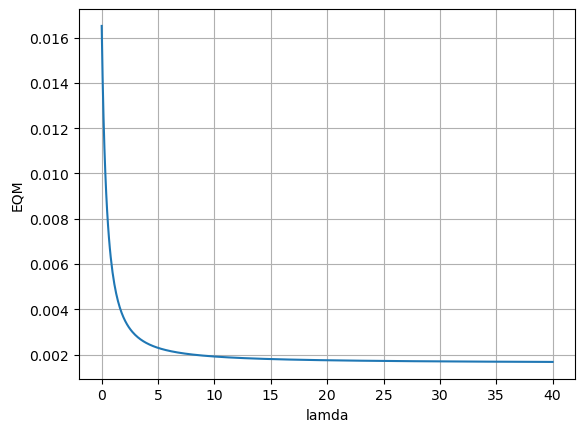

In [4]:
def plot_eqm(deb, fin):
    l_lamda = np.linspace(0, deb, fin)
    eqms = [compute_EQM(lamda, sigma2_s_hat, sigma2_b_hat, eigenvals, X_s, X_b, X_t, beta_hat_s, beta_hat_b, U) for lamda in l_lamda]
    plt.plot(l_lamda, eqms)
    plt.grid()
    plt.xlabel("lamda")
    plt.ylabel("EQM")
    plt.show()
plot_eqm(40, 500)

## Extraction des datasets

In [66]:
df_ibm = pd.read_csv('./datasets/AAPL.csv')
print(df_ibm.head(5))
print(df_ibm.shape[0])

# training dataset de 1962 à 2017 (exclu)
train_data_ibm = df_ibm[df_ibm['Date'] < '2017-01-01']
print(train_data_ibm.head(5))
print(train_data_ibm.shape[0])

# testing dataset de 2017 (inclu) à 2022
test_data_ibm = df_ibm[df_ibm['Date'] >= '2017-01-01']
print(test_data_ibm.head(5))
print(test_data_ibm.shape[0])

         Date      Open      High       Low     Close     Volume  Dividends  \
0  1980-12-12  0.100178  0.100614  0.100178  0.100178  469033600        0.0   
1  1980-12-15  0.095388  0.095388  0.094952  0.094952  175884800        0.0   
2  1980-12-16  0.088418  0.088418  0.087983  0.087983  105728000        0.0   
3  1980-12-17  0.090160  0.090596  0.090160  0.090160   86441600        0.0   
4  1980-12-18  0.092774  0.093210  0.092774  0.092774   73449600        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
10483
         Date      Open      High       Low     Close     Volume  Dividends  \
0  1980-12-12  0.100178  0.100614  0.100178  0.100178  469033600        0.0   
1  1980-12-15  0.095388  0.095388  0.094952  0.094952  175884800        0.0   
2  1980-12-16  0.088418  0.088418  0.087983  0.087983  105728000        0.0   
3  1980-12-17  0.090160  0.090596  0.090160  0.090160   86441600        0.0   
4  1980-12-18  0

In [67]:
df_hpe = pd.read_csv('./datasets/HPE.csv')
print(df_ibm.head(5))

# training dataset de 1962 à 2017 (exclu)
train_data_hpe = df_hpe[df_hpe['Date'] < '2017-01-01']
print(train_data_hpe.head(5))

# testing dataset de 2017 (inclu) à 2022
test_data_hpe = df_hpe[df_hpe['Date'] >= '2017-01-01']
print(test_data_hpe.head(5))

         Date      Open      High       Low     Close     Volume  Dividends  \
0  1980-12-12  0.100178  0.100614  0.100178  0.100178  469033600        0.0   
1  1980-12-15  0.095388  0.095388  0.094952  0.094952  175884800        0.0   
2  1980-12-16  0.088418  0.088418  0.087983  0.087983  105728000        0.0   
3  1980-12-17  0.090160  0.090596  0.090160  0.090160   86441600        0.0   
4  1980-12-18  0.092774  0.093210  0.092774  0.092774   73449600        0.0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
         Date      Open      High       Low     Close   Volume  Dividends  \
0  2015-10-19  8.988656  8.988656  8.007191  8.041203  2721233        0.0   
1  2015-10-20  7.895443  8.225837  7.895443  8.196684  1220907        0.0   
2  2015-10-21  8.381313  8.429902  7.968322  8.007191   135236        0.0   
3  2015-10-22  8.118942  8.284138  7.890581  8.235552   189261        0.0   
4  2015-10-23  8.381313  8.38131

## Test sur IBM seul

### Transformation du dataset

In [82]:
# Hyper-paramètres
d = 80

In [83]:
# Considérer uniquement 'Close'
train_ibm = train_data_ibm['Close']
test_ibm = test_data_ibm['Close']

# Scaler le dataset d'entraînement
sc = MinMaxScaler(feature_range=(0,1))
train_ibm_scaled = sc.fit_transform(train_ibm.values.reshape(-1, 1))

# Créer un dataframe pandas avec des colonnes décalées dans le temps
df_train_ibm = pd.DataFrame(train_ibm_scaled, columns=['Close'])
for i in range(1, d+1):
    df_train_ibm[f'Close_{i}'] = df_train_ibm['Close'].shift(-i)

# Séparer les données en entrées X et la cible y
X_train_ibm = df_train_ibm.drop('Close', axis=1)
y_train_ibm = df_train_ibm['Close'].shift(-(d+1))


X_train_ibm.dropna(inplace=True)
X_train_ibm.drop(X_train_ibm.index[-1], inplace=True)
y_train_ibm.dropna(inplace=True)
print("X_train_ibm=", X_train_ibm)
print("y_train_ibm=", y_train_ibm)

X_train_ibm=        Close_1   Close_2   Close_3   Close_4   Close_5   Close_6   Close_7  \
0     0.001880  0.001648  0.001721  0.001807  0.001995  0.002154  0.002299   
1     0.001648  0.001721  0.001807  0.001995  0.002154  0.002299  0.002487   
2     0.001721  0.001807  0.001995  0.002154  0.002299  0.002487  0.002834   
3     0.001807  0.001995  0.002154  0.002299  0.002487  0.002834  0.002892   
4     0.001995  0.002154  0.002299  0.002487  0.002834  0.002892  0.002791   
...        ...       ...       ...       ...       ...       ...       ...   
9007  0.821102  0.825985  0.833736  0.833504  0.838620  0.816607  0.798082   
9008  0.825985  0.833736  0.833504  0.838620  0.816607  0.798082  0.815987   
9009  0.833736  0.833504  0.838620  0.816607  0.798082  0.815987  0.835441   
9010  0.833504  0.838620  0.816607  0.798082  0.815987  0.835441  0.865050   
9011  0.838620  0.816607  0.798082  0.815987  0.835441  0.865050  0.894504   

       Close_8   Close_9  Close_10  ...  Close_71 

### Entraînement du modèle

In [84]:
#%%time
model = LinearRegression()

model.fit(X_train_ibm, y_train_ibm)

LinearRegression()

### Tester le modèle

In [85]:
last_d_values_train = train_ibm[len(train_ibm)-d:len(train_ibm)]
inputs = pd.concat([last_d_values_train, test_ibm], axis=0)
inputs_scaled  = sc.transform(inputs.values.reshape(-1, 1))

# Créer un dataframe pandas avec des colonnes décalées dans le temps
df_test_ibm = pd.DataFrame(inputs_scaled, columns=['Close'])
for i in range(1, d+1):
    df_test_ibm[f'Close_{i}'] = df_test_ibm['Close'].shift(-i)

# Séparer les données en entrées X et la cible y
X_test_ibm = df_test_ibm.drop('Close', axis=1)
y_test_ibm = df_test_ibm['Close'].shift(-(d+1))

# Enlever les valeurs NaN 
X_test_ibm.dropna(inplace=True)
# supprimer la dernière ligne (pour avoir le même nombre de lignes que y_test_ibm)
X_test_ibm.drop(X_test_ibm.index[-1], inplace=True)
y_test_ibm.dropna(inplace=True)


predicted_stock_price = model.predict(X_test_ibm)
predicted_stock_price = sc.inverse_transform(predicted_stock_price.reshape(-1, 1))

y_test_ibm = sc.inverse_transform(y_test_ibm.values.reshape(-1, 1))
print("X_test_ibm=", X_test_ibm)
print("y_test_ibm=", y_test_ibm)
print("predicted_stock_price=", predicted_stock_price)

X_test_ibm=        Close_1   Close_2   Close_3   Close_4   Close_5   Close_6   Close_7  \
0     0.798082  0.815987  0.835441  0.865050  0.894504  0.889465  0.879079   
1     0.815987  0.835441  0.865050  0.894504  0.889465  0.879079  0.879002   
2     0.835441  0.865050  0.894504  0.889465  0.879079  0.879002  0.878847   
3     0.865050  0.894504  0.889465  0.879079  0.879002  0.878847  0.887140   
4     0.894504  0.889465  0.879079  0.879002  0.878847  0.887140  0.872336   
...        ...       ...       ...       ...       ...       ...       ...   
1384  5.253523  5.127888  4.991645  5.139821  5.288992  5.323136  5.434517   
1385  5.127888  4.991645  5.139821  5.288992  5.323136  5.434517  5.480926   
1386  4.991645  5.139821  5.288992  5.323136  5.434517  5.480926  5.594959   
1387  5.139821  5.288992  5.323136  5.434517  5.480926  5.594959  5.641036   
1388  5.288992  5.323136  5.434517  5.480926  5.594959  5.641036  5.768991   

       Close_8   Close_9  Close_10  ...  Close_71  

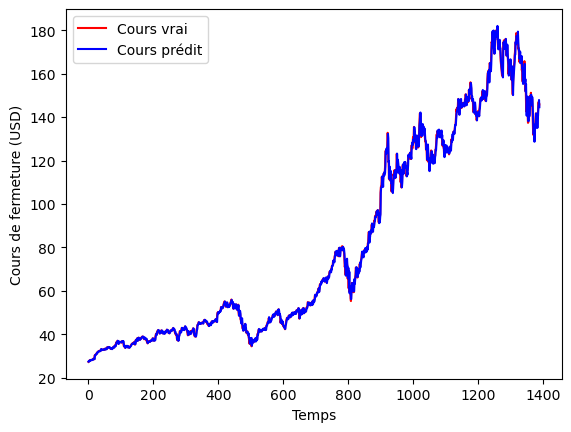

RMSE = 1.9144703808655241.


In [86]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Cours vrai')
    plt.plot(predicted, color='blue',label='Cours prédit')
    plt.xlabel('Temps')
    plt.ylabel('Cours de fermeture (USD)')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("RMSE = {}.".format(rmse))

plot_predictions(y_test_ibm, predicted_stock_price)

return_rmse(y_test_ibm, predicted_stock_price)

## Tester le transfer learning avec Small=HPE et Big=IBM

In [12]:
# Considérer uniquement 'Close'
training_set = train_data_hpe['Close']
testing_set = test_data_hpe['Close']
# Conversion en tableau CuPy puis en numpy
training_set = np.array(training_set).reshape(-1, 1)
testing_set = np.array(testing_set).reshape(-1, 1)

# Scaler le dataset d'entraînement
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

# Nouvelle structure de données avec 60 timesteps et 1 label
X_train_hpe = []
y_train_hpe = []
for i in range(d,len(training_set_scaled)):
    X_train_hpe.append(training_set_scaled[i-d:i,0])
    y_train_hpe.append(training_set_scaled[i,0])
X_train_hpe, y_train_hpe = np.array(X_train_hpe), np.array(y_train_hpe)

print("X_train_hpe=", X_train_hpe)
print("y_train_hpe=", y_train_hpe)

X_train_hpe= [[0.34494794 0.36977434 0.33951712 ... 0.09343569 0.09343569 0.05372524]
 [0.36977434 0.33951712 0.37598056 ... 0.09343569 0.05372524 0.07319124]
 [0.33951712 0.37598056 0.37985953 ... 0.05372524 0.07319124 0.03737444]
 ...
 [0.83619408 0.81581601 0.84795036 ... 0.93268195 0.93740833 0.93110679]
 [0.81581601 0.84795036 0.8385454  ... 0.93740833 0.93110679 0.8964454 ]
 [0.84795036 0.8385454  0.81615361 ... 0.93110679 0.8964454  0.89959632]]
y_train_hpe= [0.07319124 0.03737444 0.0202443  0.         0.02725195 0.1004432
 0.0996646  0.11990905 0.10355765 0.08798523 0.13236695 0.13470288
 0.1082296  0.10200061 0.1393746  0.08876367 0.0350382  0.0513896
 0.06229039 0.02647336 0.01790867 0.0210232  0.07474851 0.11445851
 0.12535929 0.13548132 0.08019867 0.11445851 0.12613796 0.10745085
 0.09421436 0.09499303 0.14326788 0.11990905 0.2631767  0.30888955
 0.25106501 0.27138149 0.30341929 0.33702038 0.34327152 0.37140249
 0.40422209 0.40187747 0.41516185 0.44485489 0.42922696 0.42531

In [13]:
inputs = np.array(list(training_set[len(training_set)-d:len(training_set),0]) + list(testing_set[:,0]))
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Préparer X_test et y_test
X_test_hpe = []
y_test_hpe = []
for i in range(d,len(inputs)):
    X_test_hpe.append(inputs[i-d:i,0])
    y_test_hpe.append(inputs[i,0])
X_test_hpe, y_test_hpe = np.array(X_test_hpe), np.array(y_test_hpe)

y_test_hpe = y_test_hpe.reshape(-1, 1)
y_test_hpe = sc.inverse_transform(y_test_hpe)
print("X_test_hpe=", X_test_hpe)
print("y_test_hpe=", y_test_hpe)

X_test_hpe= [[0.8385454  0.81615361 0.82872426 ... 0.8964454  0.89959632 0.88384078]
 [0.81615361 0.82872426 0.78786929 ... 0.89959632 0.88384078 0.88856763]
 [0.82872426 0.78786929 0.78944064 ... 0.88384078 0.88856763 0.90826182]
 ...
 [1.56479097 1.5014431  1.51252889 ... 1.10959667 1.10001629 1.14312832]
 [1.5014431  1.51252889 1.49669204 ... 1.10001629 1.14312832 1.16707943]
 [1.51252889 1.49669204 1.54895396 ... 1.14312832 1.16707943 1.14632188]]
y_test_hpe= [[11.44575214]
 [11.5690918 ]
 [11.62335777]
 ...
 [13.18999958]
 [13.06000042]
 [13.11999989]]


In [14]:
X_s = X_train_hpe
Y_s = y_train_hpe

X_b = X_train_ibm
Y_b = y_train_ibm

X_t = X_s
n = X_s.shape[0]
N = X_b.shape[0]
print("n=",n,"N=", N)

n= 244 N= 9032


In [15]:
M = compute_M(X_s, X_b)
#print("M=", M)

U, eigenvals = compute_U_eigenval(M)
#print("U=", U)
#print("eigenvals=", eigenvals)

beta_hat_s = compute_beta_hat_s_or_b(X_s, Y_s)
#print("beta_hat_s=", beta_hat_s)
beta_hat_b = compute_beta_hat_s_or_b(X_b, Y_b)
#print("beta_hat_b=", beta_hat_b)

sigma2_s_hat = compute_sigma2_hat(X_s, Y_s, beta_hat_s, n, d)
#print("sigma2_s_hat=", sigma2_s_hat)
sigma2_b_hat = compute_sigma2_hat(X_b, Y_b, beta_hat_b, N, d)
#print("sigma2_b_hat=", sigma2_b_hat)

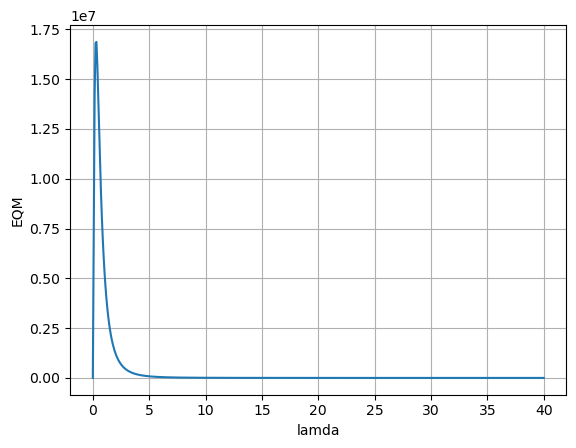

In [16]:
plot_eqm(40, 500)

In [17]:
lamda = 20
W = compute_W(lamda, X_s, X_b, X_t)

beta_hat = compute_beta_hat(W, beta_hat_s, beta_hat_b)

gamma_hat = compute_gamma_hat(lamda, X_b, X_t, beta_hat_b, beta_hat)

kappa2_hat = compute_kappa2_hat(U, X_s, X_b, gamma_hat, sigma2_s_hat, sigma2_b_hat, method="plug")

eqm = compute_EQM(lamda, sigma2_s_hat, sigma2_b_hat, eigenvals, X_s, X_b, X_t, beta_hat_s, beta_hat_b, U)
print("eqm=", eqm)

eqm= 533.9251591346716


y_test_hpe= [[11.44575214]
 [11.5690918 ]
 [11.62335777]
 ...
 [13.18999958]
 [13.06000042]
 [13.11999989]]
predicted_stock_s= [[11.39961908]
 [11.48846556]
 [11.53605187]
 ...
 [12.97800485]
 [13.33833357]
 [13.20296356]]


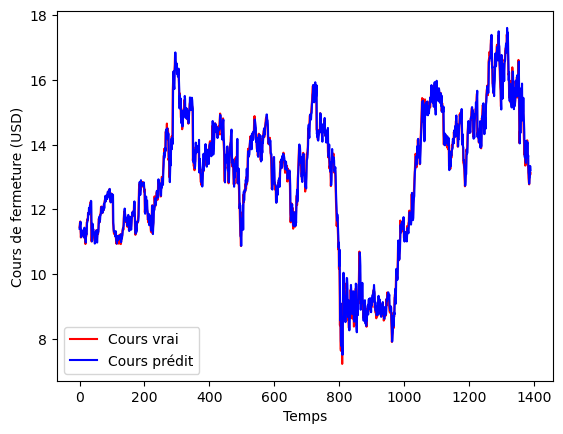

RMSE = 0.2885673854075084.


In [18]:
model = LinearRegression()
model.fit(X_train_hpe, y_train_hpe)
predicted_stock_s = model.predict(X_test_hpe)
predicted_stock_s = predicted_stock_s.reshape(-1, 1)
predicted_stock_s = sc.inverse_transform(predicted_stock_s)
print("y_test_hpe=", y_test_hpe)
print("predicted_stock_s=", predicted_stock_s)

plot_predictions(y_test_hpe, predicted_stock_s)
return_rmse(y_test_hpe, predicted_stock_s)

y_test_hpe= [[11.44575214]
 [11.5690918 ]
 [11.62335777]
 ...
 [13.18999958]
 [13.06000042]
 [13.11999989]]
predicted_stock_tf= [[11.43136844]
 [11.48289476]
 [11.5440464 ]
 ...
 [12.88174727]
 [13.3038917 ]
 [13.10194868]]


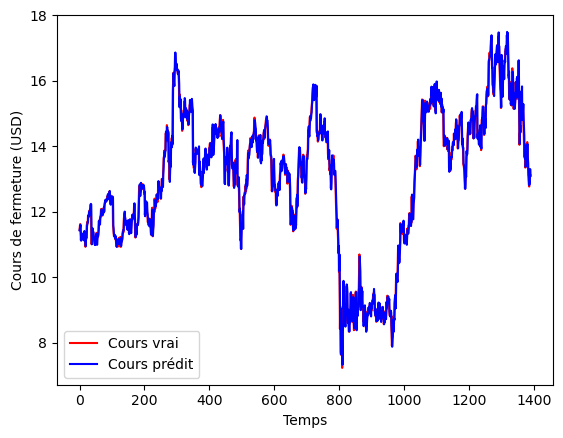

RMSE = 0.27668113961456464.


In [19]:
predicted_stock_tf = np.dot(X_test_hpe, beta_hat)
predicted_stock_tf = predicted_stock_tf.reshape(-1, 1)
predicted_stock_tf = sc.inverse_transform(predicted_stock_tf)

print("y_test_hpe=", y_test_hpe)
print("predicted_stock_tf=", predicted_stock_tf)

plot_predictions(y_test_hpe, predicted_stock_tf)
return_rmse(y_test_hpe, predicted_stock_tf)